In [1]:
import sys
if sys.platform == 'win32':
    sys.path.append(r"C:\Users\vl385\Documents\casadi-windows-py37-v3.5.1") 
else:
    sys.path.append(r"casadiinstalldir")
import casadi as ca

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import numpy.linalg as LA
from scipy.integrate import odeint
# from cfm import *
# import tensorflow as tf
# from tensorflow import keras
import tikzplotlib
import copy
from timeit import default_timer as timer
import sympy as sp

## Pre computation

In [3]:
p1, v1, a1 = sp.symbols('p1 v1 a1')
p2, v2 = sp.symbols('p2 v2')
w1, w2, w3 = sp.symbols('w1 w2 w3')
v_min, v_max = sp.symbols('v_min, v_max')
a_min, a_max = sp.symbols('a_min, a_max')
alpha, rho = sp.symbols('alpha, rho')
tau = sp.symbols('tau')

In [4]:
X = sp.Matrix([[p1],[v1]])
U = sp.Matrix([[a1]])

In [5]:
V = w2*(v1-v_max)**2 - w3*sp.log(p1**2+p2**2-2*alpha*p1*p2-rho**2)

In [6]:
V_x = sp.diff(V, X)
V_x = sp.simplify(V_x)

In [7]:
V_x

Matrix([
[-2*w3*(alpha*p2 - p1)/(2*alpha*p1*p2 - p1**2 - p2**2 + rho**2)],
[                                             2*w2*(v1 - v_max)]])

In [8]:
V_xx = sp.Matrix([sp.diff(V_x[0], X).T, sp.diff(V_x[1], X).T]).T
V_xx = sp.simplify(V_xx)

In [9]:
V_xx

Matrix([
[2*w3*(2*alpha*p1*p2 - p1**2 - p2**2 + rho**2 + 2*(alpha*p2 - p1)**2)/(2*alpha*p1*p2 - p1**2 - p2**2 + rho**2)**2,    0],
[                                                                                                               0, 2*w2]])

In [10]:
L_k = w1*a1**2

In [11]:
V_u = sp.diff(L_k, U)
V_u = sp.simplify(V_u)
V_u

Matrix([[2*a1*w1]])

In [12]:
V_uu = sp.Matrix([sp.diff(V_u[0], U).T]).T
V_uu = sp.simplify(V_uu)
V_uu

Matrix([[2*w1]])

# Simulation 

## Some functions

In [13]:
def in_control_zone(p, control_zone):
    if p >= control_zone[0] and p <= control_zone[1]:
        return True
    else:
        return False

def distance(p1, p2, angle):
    if p2 <= 0:
        dist = np.sqrt(p1**2 + p2**2 - 2*np.cos(angle)*p1*p2)
    elif p2 > 0:
        dist = np.abs(p1-p2)
    return dist

## Main classes


In [14]:
class HDV:
    lc = 3.0 # car length
    
    # velocity and input bounds      
    v_min = 0.0; v_max = 30.0
    u_min = -10.0; u_max = 5.0
    
    def __init__(self, x0, T = 0.1):
        self.st = x0
        self.input = 0.0
        self.T = T

        self.X_hist = np.empty([2,0], dtype=np.ndarray)
        self.U_hist = np.empty([0], dtype=float)
        self.X_hist = np.hstack([self.X_hist, x0.reshape([-1,1])])
        
    def set_cfm(self, model):
        self.model = model
        
    def update_measurement(self, st_h):
        self.p_h = st_h[0]; self.v_h = st_h[1]; self.u_h = st_h[2]
        
    def get_input(self):
        p = self.st[0]; v = self.st[1]
        delta_p = self.p_h - p - self.lc
        delta_v = self.v_h - v
        u = self.model.action(p, v, self.p_h, self.v_h, self.u_h)
            
#         u = max(self.u_min, min(self.u_max, u))
        if v + self.T*u > self.v_max:
            u = (self.v_max-v)/self.T
        elif v + self.T*u < self.v_min:
            u = (self.v_min-v)/self.T
        return u
    
    def car_model(self, z, t, u):
        p = z[0]; v = z[1]
        
        dz = np.zeros(2)
        dz[0] = v
        dz[1] = u
        return dz
        
    def run(self, u):
        tspan = np.linspace(0, self.T, 3)
        y = odeint(self.car_model, self.st, tspan, args=(u,)) 
        self.st = y[-1,] 
        self.input = u
        self.X_hist = np.hstack([self.X_hist, self.st.reshape([-1,1])])
        self.U_hist = np.hstack([self.U_hist, self.input])  
        
    def run_v(self, v):
        v = max(self.v_min, min(self.v_max, v))
        if (v - self.st[1])/self.T < self.u_min:
            v = self.st[1] + self.T*self.u_min
        elif (v - self.st[1])/self.T > self.u_max:
            v = self.st[1] + self.T*self.u_max
        y = self.st[0] + self.T*v
        self.st = np.array([y, v])
        self.X_hist = np.hstack([self.X_hist, self.st.reshape([-1,1])])
        self.U_hist = np.hstack([self.U_hist, self.input])     

In [15]:
class CAV:
    lc = 3.0 # car length
    
    # velocity and input bounds      
    v_min = 0.0; v_max = 30.0
    u_min = -10.0; u_max = 5.0
    
    def __init__(self, x0, T = 0.1):
        self.st = x0
        self.input = 0.0
        self.T = T
        self.X_hist = np.empty([2,0], dtype=np.ndarray)
        self.U_hist = np.empty([0], dtype=float)
        self.X_hist = np.hstack([self.X_hist, x0.reshape([-1,1])])
        
    def car_model(self, z, t, u):
        v = z[1]

        dz = np.zeros(2)
        dz[0] = v
        dz[1] = u
        return dz
        
    def run(self, u):
        u = max(self.u_min, min(self.u_max, u))
        v = self.st[1]
        if v + self.T*u > self.v_max:
            u = (self.v_max-v)/self.T
        elif v + self.T*u < self.v_min:
            u = (self.v_min-v)/self.T
        
        tspan = np.linspace(0, self.T, 3)
        y = odeint(self.car_model, self.st, tspan, args=(u,)) 
        self.st = y[-1,] 
        self.input = u
        self.X_hist = np.hstack([self.X_hist, self.st.reshape([-1,1])])
        self.U_hist = np.hstack([self.U_hist, self.input])        
        
    def run_v(self, v):
        v = max(self.v_min, min(self.v_max, v))
        if (v - self.st[1])/self.T < self.u_min:
            v = self.st[1] + self.T*self.u_min
        elif (v - self.st[1])/self.T > self.u_max:
            v = self.st[1] + self.T*self.u_max
        y = self.st[0] + self.T*v
        self.st = np.array([y, v])
        self.X_hist = np.hstack([self.X_hist, self.st.reshape([-1,1])])
        self.U_hist = np.hstack([self.U_hist, self.input])            

In [196]:
class CILQR:
    # velocity and input bounds      
    v_min = 0.0; v_max = 30.0
    u_min = -10.0; u_max = 5.0
    H_max = 20
    
    def __init__(self, N_HDV, H = 10, T = 0.1, gamma = 1e-4, lamda = 0.5, mu = 2.0):
        self.N = N_HDV
        self.H = H; self.T = T
        self.gamma = gamma; self.alpha = alpha; self.mu = mu
        
    def set_state(self, all_st):
        self.st = all_st[:,0]
        self.HDV_st = all_st[:,1:]
        
    def set_road_info(self, r, ang):
        self.r = r; self.alpha = np.cos(ang)
        
    def set_weight(self, W):
        self.W = W
        
    def update_HDV_set(self, N_HDV):
        self.N = N_HDV
        
    def update_horizon(self):
        H_f = int(-(self.st[0]/self.st[1])/self.T) if self.st[1] > 0 else np.inf
        self.H = max(1, min(H_f, self.H_max)) 
        
    def initialize(self):
        self.f_x = np.array([[1, self.T], [0, 1]])
        self.f_u = np.array([[self.T**2/2], [0.1]])
    
    def set_nominal(self, nom_inputs = None):
        self.nom_inputs = nom_inputs
        self.nom_states = np.zeros([2, self.H+1])
        self.nom_states[:,0] = self.st
        for k in range(self.H):
            x_k = self.nom_states[:,k]; u_k = self.nom_inputs[:,k]
            self.nom_states[:,k+1] = x_k \
                    + np.array([self.T*x_k[1], 0.5*self.T**2*u_k[0]])
            
    def predict_HDV(self):
        self.HDV_pred = np.zeros([self.N, 2, self.H+1])
        for i in range(self.N):
            self.HDV_pred[i,:,0] = self.HDV_st[:,i]
            for k in range(self.H):
                x_k = self.HDV_pred[i,:,k]; u_k = 0.0
                self.HDV_pred[i,:,k+1] = x_k \
                        + np.array([self.T*x_k[1], 0.5*self.T**2*u_k])
            
    def backward(self):
        X = self.nom_states[:,-1].tolist()
        for i in range(self.N):
            xhdv_k = self.HDV_pred[i,:,-1]
            X += xhdv_k.tolist()
        P1 = [self.W[1], self.W[2], self.alpha, self.r, self.v_max]
        P2 = self.W[0]
        V_k_x = self.num_V_x(X, P1); V_k_xx = self.num_V_xx(X, P1)
        
        self.q_k = np.empty(self.H, dtype=np.ndarray)
        self.Q_k = np.empty(self.H, dtype=np.ndarray)
        
        for k in range(self.H):
            X = self.nom_states[:,-2-k].tolist()
            for i in range(self.N):
                xhdv_k = self.HDV_pred[i,:,-2-k]
                X += xhdv_k.tolist()            
            
            U = self.nom_inputs[0,-1-k]

            L_k_x = self.num_V_x(X, P1); L_k_xx = self.num_V_xx(X, P1)
            L_k_u = self.num_V_u(U, P2); L_k_uu = self.num_V_uu(U, P2)
            
            P_k_x = L_k_x + np.dot(self.f_x.T, V_k_x)
            P_k_u = L_k_u + np.dot(self.f_u.T, V_k_x)
            P_k_xx = L_k_xx + LA.multi_dot([self.f_x.T, V_k_xx, self.f_x])
            P_k_uu = L_k_uu + LA.multi_dot([self.f_u.T, V_k_xx, self.f_u])
            P_k_ux = LA.multi_dot([self.f_u.T, V_k_xx, self.f_x])
            
            P_k_uu_inv = LA.inv(P_k_uu) 
            q_k = -np.dot(P_k_uu_inv, P_k_u); self.q_k[-1-k] = q_k
            Q_k = -np.dot(P_k_uu_inv, P_k_ux); self.Q_k[-1-k] = Q_k
            V_k_x = P_k_x - LA.multi_dot([P_k_u.T, P_k_uu_inv, P_k_ux]).T
            V_k_xx = P_k_xx - LA.multi_dot([P_k_ux.T, P_k_uu_inv, P_k_ux]) 

    def forward(self):
        nom_states = copy.deepcopy(self.nom_states)
        nom_inputs = copy.deepcopy(self.nom_inputs)
        for k in range(self.H):
            delta_x = self.nom_states[:,k] - nom_states[:,k]
            self.nom_inputs[:,k] += self.q_k[k].ravel() + np.dot(self.Q_k[k], delta_x)
            x_k = self.nom_states[:,k]; u_k = self.nom_inputs[:,k]
            self.nom_states[:,k+1] = x_k + \
                    np.array([self.T*x_k[1], 0.5*self.T**2*u_k[0]])
        residual = LA.norm(self.nom_inputs - nom_inputs) 
        return residual
        
    def CILQR(self, max_iters = 100, thres = 1e-3):
        self.predict_HDV()
        for i in range(max_iters):
#             self.gamma *= self.mu
            self.backward()
            res = self.forward()
#             print(i, res)
            if res <= thres:
                break
        
    def num_V_x(self, X, P):
        p1, v1 = X[0:2] 
        w2, w3, alpha, rho, v_max = P
        V = np.zeros([2,1])
        V[1,0] = 2*w2*(v1-v_max)
        for i in range(self.N):
            p2, v2 = X[2*(i+1):2*(i+2)]
            dem = (2*alpha*p1*p2-p1**2-p2**2+rho**2)
            V[0,0] += 2*w3*(-alpha*p2+p1)/dem

        return V

    def num_V_xx(self, X, P):
        p1, v1 = X[0:2] 
        w2, w3, alpha, rho, v_max = P
        V = np.zeros([2,2])
        V[1,1] = 2*w2
        for i in range(self.N):
            p2, v2 = X[2*(i+1):2*(i+2)]
            dem = (2*alpha*p1*p2-p1**2-p2**2+rho**2)**2
            V[0,0] += 2*w3*(2*alpha*p1*p2-p1**2-p2**2+rho**2+2*(alpha*p2-p1)**2)/dem
        return V

    def num_V_u(self, U, P):
        a1 = U
        w1 = P
        V = np.zeros([1,1])
        V[0,0] = 2*w1*a1
        return V

    def num_V_uu(self, U, P):
        a1 = U
        w1 = P
        V = np.zeros([1,1])
        V[0,0] = 2*w1
        return V


## Main program

In [197]:
np.random.seed(28)
T = 0.1; H = 20
HDV_ego = [True, False]
control_zone = np.array([-120, 0])

cars = []
cars.append(CAV(np.array([-150.0, 25.0])))
cars.append(HDV(np.array([-140.0, 25.0])))
cars.append(HDV(np.array([-160.0, 25.0])))
n_cars = len(cars)
N_HDV = n_cars - 1

control = CILQR(N_HDV, H, T)  
W = np.array([1.,3.,1e3])
control.set_weight(W)
r = 10; ang = np.pi/6; v_ref = 25
control.set_road_info(r, ang)
control.initialize()
all_st = np.array([cars[i].st for i in range(N_HDV+1)]).T
control.set_state(all_st)
control.set_nominal(nom_inputs = np.zeros([1, H]))

start = timer()
control.CILQR()
end = timer()
print((end-start)*1e3)
# control.set_nominal(control.nom_inputs)

L = 200 # number of simulation steps

37.85907100063923


In [198]:
enter_t = 0; exit_t = L
for t in range(L):
    print("Time step %s" %t)
    
    # Check in control zone or not
    in_CZ = [in_control_zone(car.st[0], control_zone) for car in cars] 
    if in_CZ[0]:  # CAV is in control zone
        if enter_t == 0: enter_t = t
        # Collect states of all vehicles in control zone
        control.update_HDV_set(sum(in_CZ)-1)
        all_st = np.array([cars[i].st for i in [i for i, x in enumerate(in_CZ) if x]]).T
        control.set_state(all_st)
        
        start = timer()
        control.CILQR()
        end = timer()
#         print((end-start)*1e3)
        cars[0].run(control.nom_inputs[0,0])
        control.set_nominal(np.hstack([control.nom_inputs[:,1:control.H], np.zeros([1,1])]))

    else:
        cars[0].run_v(v_ref)        
        
    
    for i in range(N_HDV):
        if in_CZ[i+1]:
            if HDV_ego[i]:
                cars[i+1].run(min(cars[i+1].u_max, (cars[i+1].v_max-cars[i+1].st[1])/T))   
            else:
                cars[i+1].run(max(cars[i+1].u_min, (cars[i+1].v_min-cars[i+1].st[1])/T))   
        else:
            cars[i+1].run_v(v_ref)        

    if not in_CZ[0]:
        if exit_t == L and enter_t != 0: exit_t = t+1
    


Time step 0
Time step 1
Time step 2
Time step 3
Time step 4
Time step 5
Time step 6
Time step 7
Time step 8
Time step 9
Time step 10
Time step 11
Time step 12
Time step 13
Time step 14
Time step 15
Time step 16
Time step 17
Time step 18
Time step 19
Time step 20
Time step 21
Time step 22
Time step 23
Time step 24
Time step 25
Time step 26
Time step 27
Time step 28
Time step 29
Time step 30
Time step 31
Time step 32
Time step 33
Time step 34
Time step 35
Time step 36
Time step 37
Time step 38
Time step 39
Time step 40
Time step 41
Time step 42
Time step 43
Time step 44
Time step 45
Time step 46
Time step 47
Time step 48
Time step 49
Time step 50
Time step 51
Time step 52
Time step 53
Time step 54
Time step 55
Time step 56
Time step 57
Time step 58
Time step 59
Time step 60
Time step 61
Time step 62
Time step 63
Time step 64
Time step 65
Time step 66
Time step 67
Time step 68
Time step 69
Time step 70
Time step 71
Time step 72
Time step 73
Time step 74
Time step 75
Time step 76
Time step

In [199]:
L = cars[0].X_hist[0,:].shape[0]
X_hist = np.zeros((n_cars,3,L))

for i in range(n_cars):
    X_hist[i,0,:] = cars[i].X_hist[0,:]
    X_hist[i,1,:] = cars[i].X_hist[1,:]
    X_hist[i,2,:-1] = cars[i].U_hist


Text(0, 0.5, 'Position (m)')

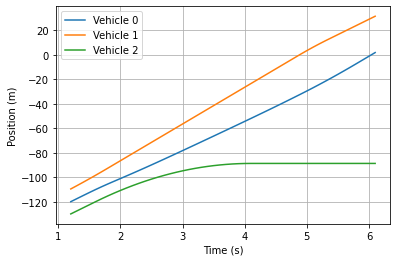

In [200]:
t_series = T*np.linspace(0,L-1,num=L)

for i in range(n_cars):
    plt.plot(t_series[enter_t:exit_t], X_hist[i,0,:][enter_t:exit_t], label = "Vehicle " + str(i))
plt.grid()
plt.legend(loc="upper left")
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
# filename = 'plots/postion.png'
# plt.savefig(filename)
# filename = 'plots/position' +'.tex'
# tikzplotlib.save(filename)

Text(0, 0.5, 'Velocity (m)')

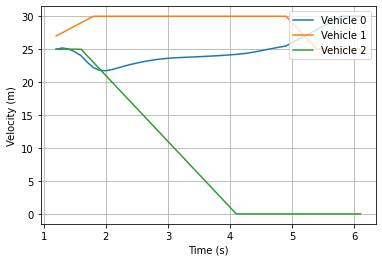

In [201]:
for i in range(n_cars):
    plt.plot(t_series[enter_t:exit_t], X_hist[i,1,:][enter_t:exit_t], label = "Vehicle " + str(i))
plt.grid()
plt.legend(loc="upper right")
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m)')
# filename = 'plots/velocity.png'
# plt.savefig(filename)
# filename = 'plots/velocity' +'.tex'
# tikzplotlib.save(filename)

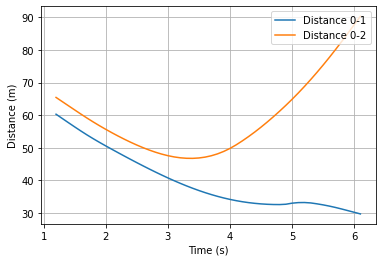

In [202]:
d = np.zeros([N_HDV,L])
for i in range(N_HDV):
    for k in range(L):
        p1 = X_hist[0,0,k]; p2 = X_hist[i+1,0,k]
        d[i,k] = distance(p1, p2, ang)
    
for i in range(N_HDV):
    plt.plot(t_series[enter_t:exit_t], d[i, enter_t:exit_t], label = "Distance " + str(0) + "-" + str(i+1))
plt.grid()
plt.xlabel('Time (s)')
plt.ylabel('Distance (m)')
plt.legend(loc="upper right")
# filename = 'plots/distance.png'
# plt.savefig(filename)
# filename = 'plots/distance' +'.tex'
# tikzplotlib.save(filename)